### Universidad Nacional de Córdoba - Facultad de Matemática, Astronomía, Física y Computación

### Diplomatura en Ciencia de Datos, Aprendizaje Automático y sus Aplicaciones 2021
Búsqueda y Recomendación para Textos Legales

Mentor: Jorge E. Pérez Villella

# Práctico Introducción al Aprendizaje Automático

Integrantes:

- Christian Oviedo
- Francisco Correa

El objetivo de este práctico es probar distintos modelos de clasificación para evaluar la performance y la exactitud de predicción de cada modelo. 

* Utilizando el corpus normalizado en el práctico anterior, transformar el texto en vectores numéricos utilizando scikit-learn comparando los 3 modelos de vectorización. Explicar cada uno estos modelos.

* Clasificar los documentos por fuero. Trabajaremos con los siguientes modelos de clasificación de la librería scikit-learn: Logistic Regresion, Naive Bayes y SVM. En cada modelo probar distintos hiperparámetros, generar la Matriz de Confusión y la Curva ROC. Explicar los resultados obtenidos.

* Determinar y justificar cual es el modelo con mejor performance y predecir el fuero de un documento utilizando el mejor modelo.


Fecha de Entrega: 15 de agosto de 2021

Se carga el corpus normalizado en en el práctico anterior

In [1]:
#!conda install -y yellowbrick

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn import linear_model
from sklearn import metrics
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import HashingVectorizer



from sklearn.naive_bayes import MultinomialNB

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold

from sklearn import svm, datasets


import itertools as it


Esta clase permite hacer un gridsearch sobre diferentes modelos. Ver http://www.davidsbatista.net/blog/2018/02/23/model_optimization/ 

In [5]:
corpus_file_name = 'cleaned_corpus.csv'
cleaned_corpus = pd.read_csv(corpus_file_name)

In [6]:
cleaned_corpus.head()

,Unnamed: 0,text,id,classifier
0,0,dato causa sede ciudad cordoba dependencia juz...,4de122c24ab1606c9d67f4ff9e656143,Documentos/MENORES
1,1,univoco fecha materia revista familia tribunal...,1f9cdcb2c2596656b540c1271fc2d843,Documentos/MENORES
2,2,juzgado juventud violencia familiar 8ª cordoba...,17dcae14592fc6e87680ccb4251d9395,Documentos/MENORES
3,3,auto caratulado a. a. denuncia violencia gener...,4b3ae58648b6267ebb332feec8002588,Documentos/MENORES
4,4,juzg adolescencia violencia familiar 4ta cba s...,1316026beaa1d7e6530bdfe7e54f7b5c,Documentos/MENORES


Generamos los sets de entrenamiento y de testing

In [23]:
X = cleaned_corpus['text']  
y = cleaned_corpus['classifier']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

# Modelos de Vectorización

Esta función recibe una lista de documentos para entrenar (X_train), una lista de documentos para hacer el testing (X_test )del modelo entrenado, y un vectorizer para transformar a vectores los documentos de entrenamiento y prueba. Devuelve dos matrices sparse donde cada fila es un vector que representa un documento.

In [25]:
def get_vectors(X_train, X_test, vectorizer):
    
    X_train_vect = vectorizer.fit_transform(X_train)
    X_text_vect = vectorizer.transform(X_test)
    
    return (X_train_vect, X_text_vect)

## Vectorización con CountVectorizer
Este esquema de vectorización es el más simple y básico. Se genera un vector que representa todas las palabras del corpus. Cada documento es representado como una instancia del vector anterior indicando la cantidad de veces que aparece cada palabra. Notar que este modelo de vectorización esta sesgado para el caso en que tengamos palabras poco frecuentes pero muy significativas para clasificar documentos y también para palabras que aparezcan 'mucho', pero que aparezca en todos los documentos. En el último caso, si tratamos de diferenciar los documentos en base a las palabras que los componen,  que las palabras aparezcan en todos ellos, no aporta información

In [26]:
count_vect = CountVectorizer()

X_train_counts , X_test_counts = get_vectors(X_train, X_test, count_vect)

X_train_counts.shape

(162, 15696)

In [31]:
print ("X_train")
print (f"Cantidad de documentos:{X_train_counts.shape[0]}, Cantidad de dimensiones por documento: {X_train_counts.shape[1]} ")

print ("X_test")
print (f"Cantidad de documentos:{X_test_counts.shape[0]}, Cantidad de dimensiones por documento: {X_test_counts.shape[1]} ")

X_train
Cantidad de documentos:162, Cantidad de dimensiones por documento: 15696 
X_test
Cantidad de documentos:81, Cantidad de dimensiones por documento: 15696 


In [35]:
#count_vect.vocabulary_


## Vectorización con TfidfVectorizer
Cuando vimos el método CountVectorizer, vimos que no es suficiente únicamente contar la cantidad de veces que aparece una palabra en un documento, puesto que no es lo mismo que esa palabra aparezca en el resto de los documentos (en este caso, la palabra no brinda información relevante) a que aparezca en un número reducido de documentos (en este caso la palabra si brinda información relevante.)
Es por eso que es necesario contar con algún método que permita hacer este tipo de distinciones a la hora de expresar documentos como vectores.

El método TF-IDF (Term Frequency – Inverse Documento Frequency) busca generar vectores que indican no solamente cuanto aparece una palabra en un documento, sino que tan frecuente es esa palabra en el resto de los documentos.

TF(palabra,documento) =  $\frac{\textrm{Número de veces que la palabra aparece en el documento}}{\textrm{Número de palabras diferentes en el documento}}$


DF(palabra,documentos) =  $\frac{\textrm{Cantidad de documentos que tienen la palabra}}{\textrm{cantidad de documentos}}$


IDF(palabra,documentos) = $ log ({\frac{\textrm{cantidad de documentos}}{\textrm{Cantidad de documentos que tienen la palabra}}})$

Notar que en IDF, cuando la cantidad de documentos que tienen la palabra, se acerca a la cantidad de documentos, el resultado de la división se acerca a 1 y por consiguiente, el logartimo a 0.

**TF - IDF = (palabra, documentos, documento) = TF (palabra, documento) $\times$ IDF (palabra, documentos)**



In [40]:
vectorizer = TfidfVectorizer()

X_train_counts_tfidf , X_test_counts_tfidf = get_vectors(X_train, X_test, vectorizer)


X_train_tfidf = vectorizer.fit_transform(X_train) # remember to use the original X_train set
X_train_tfidf.shape

(162, 15696)

In [41]:
print ("X_train")
print (f"Cantidad de documentos:{X_train_counts_tfidf.shape[0]}, Cantidad de dimensiones por documento: {X_train_counts_tfidf.shape[1]} ")

print ("X_test")
print (f"Cantidad de documentos:{X_test_counts_tfidf.shape[0]}, Cantidad de dimensiones por documento: {X_test_counts_tfidf.shape[1]} ")

X_train
Cantidad de documentos:162, Cantidad de dimensiones por documento: 15696 
X_test
Cantidad de documentos:81, Cantidad de dimensiones por documento: 15696 


In [42]:
#vectorizer.vocabulary_

# Clasificación usando diferentes modelos

## Curva ROC


Se puede utilizar un gráfico AUC ROC (Área bajo la curva de características operativas del receptor) para visualizar el rendimiento de un modelo entre la sensibilidad y la especificidad. La sensibilidad se refiere a la capacidad de identificar correctamente las entradas que pertenecen a la clase positiva. La especificidad se refiere a la capacidad de identificar correctamente las entradas que pertenecen a la clase negativa. Dicho de otra manera, una gráfica AUC ROC puede ayudar a identificar qué tan bien su modelo es capaz de distinguir entre clases.


En los problemas del mundo real, a menudo hay una superposición entre las clases, lo que significa que detectar todos los verdaderos negativos y verdaderos positivos puede ser desafío muchas veces de imposible solución. Se muestra a continuación una ilustración de lo que se esta comentando:


<img src="images/ROC_curve.png">



Notar que dependiendo donde se ubique el umbral de predicción, cambiará el número de TP, TN, FP y FN. Notar también que en el gráfico anterior, las distribuciones se solapan (lo que sucede con frecuencia en problemas de la vida real), lo que trae como consecuencia, tener inevitablemente FN y FP.

El tipo de problemática que quiera resolver, es el que indicará hacia donde muevo el umbral. Supongamos por ejemplo que lo que estamos tratando de clasificar es si un paciente tiene cáncer o no. Es claro que en este ejemplo, no quiero tener falsos negativos (FNwww.www). No es aceptable que a una persona que tiene cáncer, le de un diagnóstico en el cual indica que esta sana. En este caso, voy a mover el umbral de predicción hacia la izquierda de manera tal que no exista la posibilidad de generar falsos negativos (FN). Al mover el umbral de esta manera, voy a aumentar inevitablemente la cantidad de falsos positivos (FP), los cuales luego puedo descartar con estudios más específicos.

Volviendo gráfico AUC ROC, una puntuación AUC de 1 significa que el modelo puede distinguir con precisión entre las dos clases el 100% del tiempo, es decir, estamos frente a un clasificador ideal. Una puntuación de 0,5 significa que el modelo no puede determinar entre las dos clases y, en esencia, está adivinando. La curva ROC es la gráfica de la tasa de verdaderos positivos del modelo frente a la tasa de falsos positivos.



$\textrm{TPR} =  \frac{\textrm{TP}} {{\textrm{TP}}➕{\textrm{FN}} }$

$\textrm{FPR} =  \frac{\textrm{FP}} {{\textrm{FP}}➕{\textrm{TN}} }$


De lo antes indicado, entonces al momento de evaluar los modelos de clasificación, buscaremos o nos quedaremos con aquel modelo y los correspondientes híper parámetros para los cuales el área bajo la curva ROC sea lo más cercana a 1.

<img src="images/ROC_curve_values.png">

La clasificación que se solicita en la mentoria, es una clasificación multi clase, es por ello que debemos extender el concepto de curvas ROC a curvas ROC para clasificaciones multi clases

Lo que se estuvo presentando hasta el momento esta orientado a clasificaciones binarias. Como se puede hacer para llevar o reutilizar lo antes mencionado en clasificaciones multi clases. Una estrategia para lograr esto, es que las curvas ROC se pueden trazar con la metodología de usar una clase frente al resto. Utilizando uno contra el resto para cada clase, se tendrá el mismo número de curvas que clases. La puntuación AUC también se puede calcular para cada clase individualmente.


<img src="images/ROC_curve_multiclass.png">

El componente que utilizaremos para realizar la Curva ROC para clasificaciones multi clases, es el provisto por  **yellowbrick** (https://www.scikit-yb.org/en/latest/api/classifier/rocauc.html)


ROC Multiclass: https://medium.com/swlh/how-to-create-an-auc-roc-plot-for-a-multiclass-model-9e13838dd3de

La función **test_model** recibe un modelo de clasificación (por ejemplo Naive Bayes, Regresión Logística, etc ), los sets de entrenamiento y testing, y muestra:


-	La métricas: precisión, recall, f1-score
-	La matriz de confusión
-	Curca ROC Multiclase y el AUC correspondiente

Este método usa el método plot_ROC_curve para poder visualizar la curva ROC multiclase


In [58]:
from yellowbrick.classifier import ROCAUC

def plot_ROC_curve(model, xtrain, ytrain, xtest, ytest , ax , macro = True, micro = True , per_class = True):

    # Creating visualization with the readable labels
    visualizer = ROCAUC(estimator = model , ax = ax , macro = macro, micro = micro , per_class = per_class)
                                        
    # Fitting to the training data first then scoring with the test data                                    
    visualizer.fit(xtrain, ytrain)
    visualizer.score(xtest, ytest)
    visualizer.show()
    
    #return visualizer


def test_model(model, X_train, y_train, X_test, y_test ):
    
    model.fit(X_train, y_train)
    y_test_pred = model.predict(X_test)
    print(metrics.classification_report(y_test, y_test_pred ))

    fig, ax = plt.subplots(figsize=(10, 6))
    ax.set_title('Confusion Matrx')

    disp =metrics.plot_confusion_matrix(model, X_test, y_test, display_labels= ["FAMILIA" ,"LABORAL" , "MENORES" , "PENAL" ], ax = ax)
    #disp.confusion_matrix
    
    fig1, ax1 = plt.subplots(figsize=(10, 6))
    ax1.set_title('ROC')
        
    plot_ROC_curve(model = model, xtrain = X_train, ytrain = y_train, xtest = X_test, ytest = y_test , ax = ax1 )
    

## Logistic Regression

                    precision    recall  f1-score   support

Documentos/FAMILIA       0.98      0.95      0.97        44
Documentos/LABORAL       1.00      1.00      1.00        12
Documentos/MENORES       0.82      0.90      0.86        10
  Documentos/PENAL       1.00      1.00      1.00        15

          accuracy                           0.96        81
         macro avg       0.95      0.96      0.96        81
      weighted avg       0.96      0.96      0.96        81



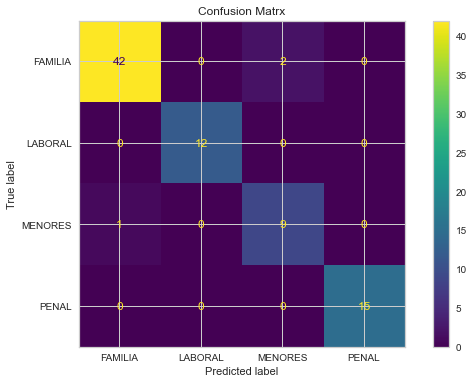

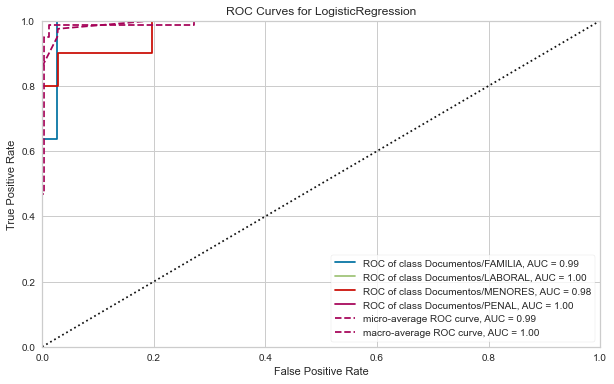

In [59]:
ltest = linear_model.LogisticRegression()
setattr(ltest, 'multi_class' , 'ovr')
setattr(ltest, 'solver' , 'liblinear')

test_model(ltest,X_train_counts, y_train, X_test_counts, y_test )

                    precision    recall  f1-score   support

Documentos/FAMILIA       0.98      0.95      0.97        44
Documentos/LABORAL       1.00      1.00      1.00        12
Documentos/MENORES       0.82      0.90      0.86        10
  Documentos/PENAL       1.00      1.00      1.00        15

          accuracy                           0.96        81
         macro avg       0.95      0.96      0.96        81
      weighted avg       0.96      0.96      0.96        81



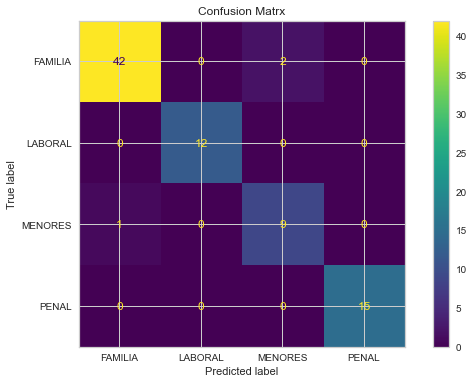

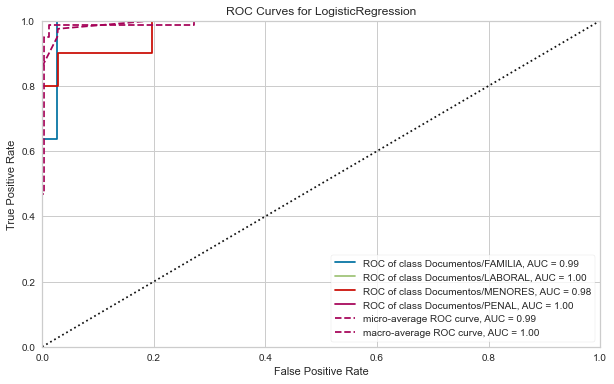

In [60]:
lm = linear_model.LogisticRegression(multi_class='ovr', solver='liblinear')

test_model(lm,X_train_counts, y_train, X_test_counts, y_test )

## Naive Bayes

                    precision    recall  f1-score   support

Documentos/FAMILIA       0.98      0.93      0.95        44
Documentos/LABORAL       1.00      1.00      1.00        12
Documentos/MENORES       0.75      0.90      0.82        10
  Documentos/PENAL       1.00      1.00      1.00        15

          accuracy                           0.95        81
         macro avg       0.93      0.96      0.94        81
      weighted avg       0.96      0.95      0.95        81



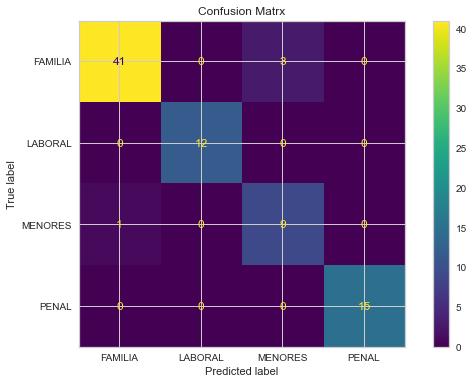

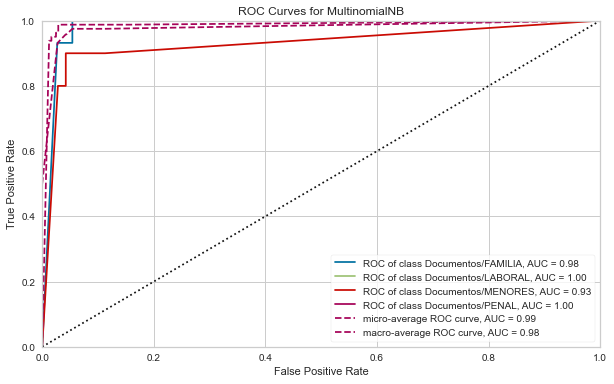

In [61]:
nb = MultinomialNB()
test_model(nb,X_train_counts, y_train, X_test_counts, y_test )

## SVM

                    precision    recall  f1-score   support

Documentos/FAMILIA       0.96      1.00      0.98        44
Documentos/LABORAL       1.00      1.00      1.00        12
Documentos/MENORES       1.00      0.80      0.89        10
  Documentos/PENAL       1.00      1.00      1.00        15

          accuracy                           0.98        81
         macro avg       0.99      0.95      0.97        81
      weighted avg       0.98      0.98      0.97        81



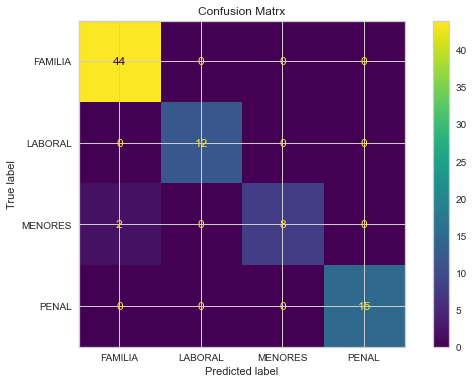

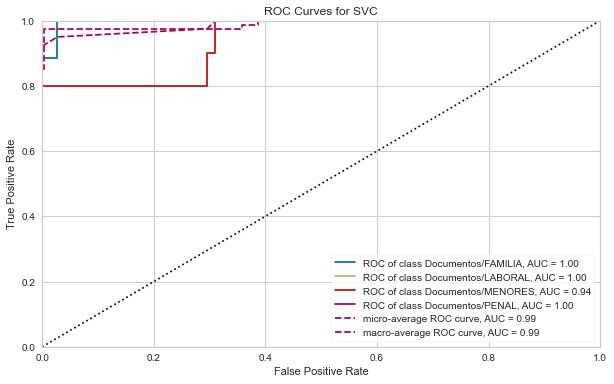

In [62]:
rbf = svm.SVC(kernel='rbf')

test_model(rbf,X_train_counts, y_train, X_test_counts, y_test )


In [63]:
poly = svm.SVC(kernel='poly', degree=3 )


/Users/coviedo/opt/anaconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/coviedo/opt/anaconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/coviedo/opt/anaconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _wa

                    precision    recall  f1-score   support

Documentos/FAMILIA       0.60      1.00      0.75        44
Documentos/LABORAL       0.00      0.00      0.00        12
Documentos/MENORES       1.00      0.30      0.46        10
  Documentos/PENAL       1.00      0.33      0.50        15

          accuracy                           0.64        81
         macro avg       0.65      0.41      0.43        81
      weighted avg       0.64      0.64      0.56        81



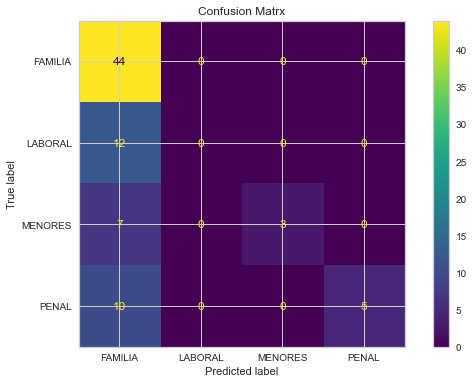

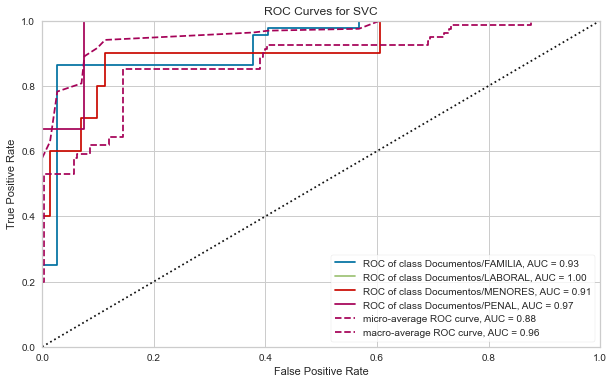

In [64]:
test_model(poly,X_train_counts, y_train, X_test_counts, y_test )

# Random Forest

                    precision    recall  f1-score   support

Documentos/FAMILIA       0.98      1.00      0.99        44
Documentos/LABORAL       1.00      1.00      1.00        12
Documentos/MENORES       1.00      0.90      0.95        10
  Documentos/PENAL       1.00      1.00      1.00        15

          accuracy                           0.99        81
         macro avg       0.99      0.97      0.98        81
      weighted avg       0.99      0.99      0.99        81



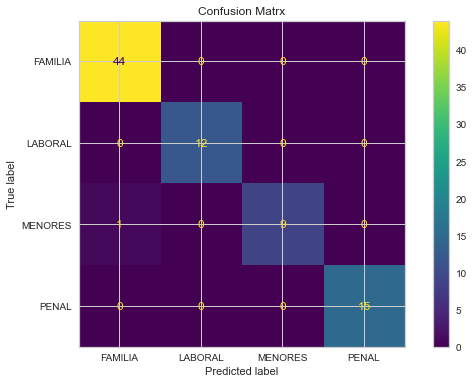

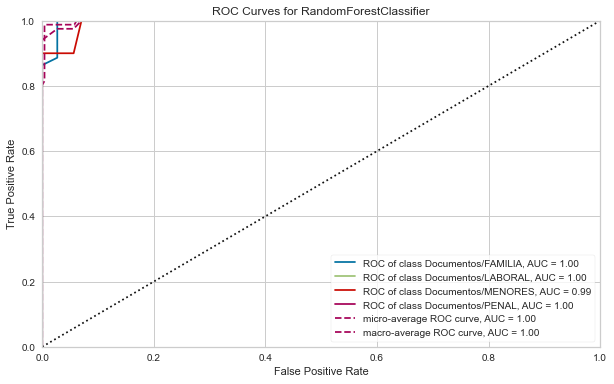

In [67]:
from sklearn.ensemble import RandomForestClassifier

randomForest = RandomForestClassifier()

test_model(randomForest,X_train_counts, y_train, X_test_counts, y_test )

# Anexo

## Optimización de modelos

Realizamos una implementación de gridsearch con cross validation, que permite pasar diferentes modelos de sickit-learn a ajustar. 
La idea es que este método nos permita hacer pruebas de manera sencilla de diferentes métodos con diferentes parámetros. Luego en base a estos resultados, elegimos que modelos y parámetros presentar en el apartado * Clasificación usando diferentes modelos*

Al método **train_modelos** se le pasan:
-	 Dos diccionarios: los modelos y los parámetros.
-	 Los sets de entrenamiento y test
-	 La cantidad de folds

El método hace el entrenamiento de todos los modelos en base a los parámetros que se le indican y usando el CV indicado.


Otra alternativa a esta implementación puede ser la indicada en http://www.davidsbatista.net/blog/2018/02/23/model_optimization/ . Preferimos implementar una versión propia para poder entender más profundamente los conceptos vistos en la diplomatura

In [51]:
models1x = {
    'LogisticRegressionClassifier': linear_model.LogisticRegression(),
    'SVM': svm.SVC()
    
}

params1x = {
    'LogisticRegressionClassifier': { "solver":["liblinear"], "multi_class":["ovr"], "penalty":["l2"] , "C": [1.0,0.7]  } ,
    'SVM':{"kernel" :['poly' , 'rbf'] , 'degree':[1,2,3]} 
}



models1 = {
    'LogisticRegressionClassifier': linear_model.LogisticRegression(),
    'SVM': svm.SVC(),
    'MultinomialNB': MultinomialNB(),
    'SVM_poly': svm.SVC(),
    'RandomForset': RandomForestClassifier()
}

params1 = {
    'LogisticRegressionClassifier': { "solver":["liblinear"], "multi_class":["ovr"], "penalty":["l2"] , "C": [1.0,0.7]  } ,
    'SVM':{"kernel" :['rbf'] } ,
    'MultinomialNB':{"alpha" :[1.0] },
    'SVM_poly':{"kernel" :['poly'] ,'degree':[3,4,5,6]}    ,
    'RandomForset': {"n_estimators" : [100]}
} 


scoring = {
           'precision': metrics.make_scorer(metrics.precision_score, average = 'macro'),
           'recall': metrics.make_scorer(metrics.recall_score, average = 'macro'),
           'f1_macro': metrics.make_scorer(metrics.f1_score, average = 'macro'),
           'f1_weighted': metrics.make_scorer(metrics.f1_score, average = 'weighted') ,
            'accuracy': metrics.make_scorer(metrics.accuracy_score)}

grid={"multi_class": ["ovr"], "solver":["liblinear"] , "penalty":["l1","l2"]}# l1 lasso l2 ridge
logreg=linear_model.LogisticRegression()
logreg_cv=GridSearchCV(logreg,param_grid = grid,cv=2 , scoring=scoring , refit=False , return_train_score = False)
logreg_cv.fit(X_train_counts,y_train)
logreg_cv.cv_results_


logreg_cv.best_params_


helper1 = EstimatorSelectionHelper(models1, params1)
helper1.fit(X_train_counts, y_train, n_jobs=4 , cv=4 , verbose = 0 , scoring=scoring )

helper1.score_summary()

In [55]:
from copy import copy, deepcopy

#def train_model(model, folds_index, X_train, Y_train):

def generate_model_params(model_params):
    
    allNames = sorted(model_params)
    combinations = it.product(*(model_params[Name] for Name in allNames))
    return (list(combinations) , allNames)


def train_model(model, params_names, param_combination, folds_index, X_train, Y_train , X_test, Y_test , output_dict = True , random_state = None):
    
    param_combination = list(param_combination)
    print ("train model")
    print (f"{model} {params_names} {param_combination}")
   
    
    cloned_model = deepcopy(model)
    
    
    for param_name , param_value in zip(params_names,param_combination ):
        #print (f"{param_name} =  {param_value}")
        setattr(cloned_model , param_name , param_value)

    if type(random_state) == int:
        setattr(cloned_model , "random_state" , random_state)
        
    print (cloned_model)
    
    results = []
    
    for train_index, test_index in folds_index:
   
        cloned_model_tmp = deepcopy(cloned_model)
        #print (f"{train_index}")
           
    
        X_train_tmp, X_test_tmp = X_train[train_index], X_train[test_index]
        
        y_train_tmp, y_test_tmp = Y_train[train_index], Y_train[test_index] 
    
        cloned_model_tmp.fit(X_train_tmp,y_train_tmp)
       
    
        y_test_val_pred = cloned_model_tmp.predict(X_test_tmp)
        
        train_result = metrics.classification_report(y_test_tmp, y_test_val_pred , output_dict = output_dict )
        
        print(train_result)
        
        results.append ((f"{model}",f"{params_names} {param_combination}", train_result))
    
    
    cloned_model_tmp = deepcopy(cloned_model)
    
    
    cloned_model_tmp.fit(X_train,Y_train)
        
    y_test_pred = cloned_model_tmp.predict(X_test)
    
    test_result = metrics.classification_report(Y_test, y_test_pred , output_dict = output_dict )
    
    results.append ((f"{model}",f"{params_names} {param_combination}", test_result))
    
    print("Test")
    print(test_result)
    
    return results
    
    

def train_models(X_train,Y_train,X_test, Y_test, cv=5,shuffle=True, models=None ,params=None , output_dict = True , random_state = None):
    
    results = []
    
    kf = KFold(n_splits=cv, random_state=random_state, shuffle=shuffle )
   
    
    folds_index = [(train_index, test_index) for train_index, test_index in kf.split(X_train)  ]

    for param_model in params.keys():
    
        params_combination, params_names = generate_model_params(params.get(param_model))
        #print (f"Modelo a ejecutar: {param_model}, parámetros a probar: {params_combination} , nombre de los parámetros: {params_names} ")
        
        for param_combination in params_combination:
            #print (f"{param_model}: {param_combination} ")
            
            model_result = train_model(model = models.get(param_model),params_names = params_names, param_combination = param_combination, folds_index = folds_index, X_train = X_train, Y_train = Y_train , X_test = X_test, Y_test = Y_test , output_dict = output_dict , random_state = random_state )     
            
            results.extend(model_result)
    return results        

In [56]:
#y_train.values

In [57]:
results  = train_models(X_train= X_train_counts, Y_train =y_train.values ,  X_test = X_test_counts, Y_test = y_test.values,  models = models1 , params = params1 , cv=5 , output_dict = False , random_state = 42 )

train model
LogisticRegression() ['C', 'multi_class', 'penalty', 'solver'] [1.0, 'ovr', 'l2', 'liblinear']
LogisticRegression(multi_class='ovr', random_state=42, solver='liblinear')
                    precision    recall  f1-score   support

Documentos/FAMILIA       1.00      1.00      1.00        15
Documentos/LABORAL       1.00      1.00      1.00         7
Documentos/MENORES       1.00      1.00      1.00         3
  Documentos/PENAL       1.00      1.00      1.00         8

          accuracy                           1.00        33
         macro avg       1.00      1.00      1.00        33
      weighted avg       1.00      1.00      1.00        33

                    precision    recall  f1-score   support

Documentos/FAMILIA       1.00      1.00      1.00        22
Documentos/LABORAL       1.00      1.00      1.00         2
Documentos/MENORES       1.00      1.00      1.00         3
  Documentos/PENAL       1.00      1.00      1.00         6

          accuracy               

Test
                    precision    recall  f1-score   support

Documentos/FAMILIA       0.96      1.00      0.98        44
Documentos/LABORAL       1.00      1.00      1.00        12
Documentos/MENORES       1.00      0.80      0.89        10
  Documentos/PENAL       1.00      1.00      1.00        15

          accuracy                           0.98        81
         macro avg       0.99      0.95      0.97        81
      weighted avg       0.98      0.98      0.97        81

train model
MultinomialNB() ['alpha'] [1.0]
MultinomialNB()
                    precision    recall  f1-score   support

Documentos/FAMILIA       1.00      1.00      1.00        15
Documentos/LABORAL       1.00      1.00      1.00         7
Documentos/MENORES       1.00      1.00      1.00         3
  Documentos/PENAL       1.00      1.00      1.00         8

          accuracy                           1.00        33
         macro avg       1.00      1.00      1.00        33
      weighted avg       1.00 

/Users/coviedo/opt/anaconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/coviedo/opt/anaconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/coviedo/opt/anaconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _wa

                    precision    recall  f1-score   support

Documentos/FAMILIA       0.71      1.00      0.83        22
Documentos/LABORAL       0.00      0.00      0.00         2
Documentos/MENORES       1.00      0.33      0.50         3
  Documentos/PENAL       1.00      0.17      0.29         6

          accuracy                           0.73        33
         macro avg       0.68      0.38      0.40        33
      weighted avg       0.75      0.73      0.65        33

                    precision    recall  f1-score   support

Documentos/FAMILIA       0.54      1.00      0.70        15
Documentos/LABORAL       0.00      0.00      0.00         8
Documentos/MENORES       1.00      0.25      0.40         4
  Documentos/PENAL       1.00      0.60      0.75         5

          accuracy                           0.59        32
         macro avg       0.63      0.46      0.46        32
      weighted avg       0.53      0.59      0.49        32



/Users/coviedo/opt/anaconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/coviedo/opt/anaconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/coviedo/opt/anaconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _wa

                    precision    recall  f1-score   support

Documentos/FAMILIA       0.45      1.00      0.62        13
Documentos/LABORAL       0.00      0.00      0.00         6
Documentos/MENORES       1.00      0.33      0.50         3
  Documentos/PENAL       1.00      0.20      0.33        10

          accuracy                           0.50        32
         macro avg       0.61      0.38      0.36        32
      weighted avg       0.59      0.50      0.40        32

                    precision    recall  f1-score   support

Documentos/FAMILIA       0.60      1.00      0.75        15
Documentos/LABORAL       0.00      0.00      0.00         2
Documentos/MENORES       1.00      0.17      0.29         6
  Documentos/PENAL       1.00      0.67      0.80         9

          accuracy                           0.69        32
         macro avg       0.65      0.46      0.46        32
      weighted avg       0.75      0.69      0.63        32



/Users/coviedo/opt/anaconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/coviedo/opt/anaconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/coviedo/opt/anaconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _wa

Test
                    precision    recall  f1-score   support

Documentos/FAMILIA       0.60      1.00      0.75        44
Documentos/LABORAL       0.00      0.00      0.00        12
Documentos/MENORES       1.00      0.30      0.46        10
  Documentos/PENAL       1.00      0.33      0.50        15

          accuracy                           0.64        81
         macro avg       0.65      0.41      0.43        81
      weighted avg       0.64      0.64      0.56        81

train model
SVC() ['degree', 'kernel'] [4, 'poly']
SVC(degree=4, kernel='poly', random_state=42)
                    precision    recall  f1-score   support

Documentos/FAMILIA       0.50      1.00      0.67        15
Documentos/LABORAL       0.00      0.00      0.00         7
Documentos/MENORES       0.00      0.00      0.00         3
  Documentos/PENAL       1.00      0.38      0.55         8

          accuracy                           0.55        33
         macro avg       0.38      0.34      0.30    

/Users/coviedo/opt/anaconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/coviedo/opt/anaconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/coviedo/opt/anaconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _wa

                    precision    recall  f1-score   support

Documentos/FAMILIA       0.69      1.00      0.81        22
Documentos/LABORAL       0.00      0.00      0.00         2
Documentos/MENORES       0.00      0.00      0.00         3
  Documentos/PENAL       1.00      0.17      0.29         6

          accuracy                           0.70        33
         macro avg       0.42      0.29      0.28        33
      weighted avg       0.64      0.70      0.60        33

                    precision    recall  f1-score   support

Documentos/FAMILIA       0.52      1.00      0.68        15
Documentos/LABORAL       0.00      0.00      0.00         8
Documentos/MENORES       1.00      0.25      0.40         4
  Documentos/PENAL       1.00      0.40      0.57         5

          accuracy                           0.56        32
         macro avg       0.63      0.41      0.41        32
      weighted avg       0.52      0.56      0.46        32



/Users/coviedo/opt/anaconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/coviedo/opt/anaconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/coviedo/opt/anaconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _wa

                    precision    recall  f1-score   support

Documentos/FAMILIA       0.42      1.00      0.59        13
Documentos/LABORAL       0.00      0.00      0.00         6
Documentos/MENORES       0.00      0.00      0.00         3
  Documentos/PENAL       1.00      0.10      0.18        10

          accuracy                           0.44        32
         macro avg       0.35      0.28      0.19        32
      weighted avg       0.48      0.44      0.30        32

                    precision    recall  f1-score   support

Documentos/FAMILIA       0.50      1.00      0.67        15
Documentos/LABORAL       0.00      0.00      0.00         2
Documentos/MENORES       1.00      0.17      0.29         6
  Documentos/PENAL       1.00      0.11      0.20         9

          accuracy                           0.53        32
         macro avg       0.62      0.32      0.29        32
      weighted avg       0.70      0.53      0.42        32



/Users/coviedo/opt/anaconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/coviedo/opt/anaconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/coviedo/opt/anaconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _wa

Test
                    precision    recall  f1-score   support

Documentos/FAMILIA       0.58      1.00      0.73        44
Documentos/LABORAL       0.00      0.00      0.00        12
Documentos/MENORES       1.00      0.20      0.33        10
  Documentos/PENAL       1.00      0.20      0.33        15

          accuracy                           0.60        81
         macro avg       0.64      0.35      0.35        81
      weighted avg       0.62      0.60      0.50        81

train model
SVC() ['degree', 'kernel'] [5, 'poly']
SVC(degree=5, kernel='poly', random_state=42)
                    precision    recall  f1-score   support

Documentos/FAMILIA       0.50      1.00      0.67        15
Documentos/LABORAL       0.00      0.00      0.00         7
Documentos/MENORES       0.00      0.00      0.00         3
  Documentos/PENAL       1.00      0.38      0.55         8

          accuracy                           0.55        33
         macro avg       0.38      0.34      0.30    

/Users/coviedo/opt/anaconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/coviedo/opt/anaconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/coviedo/opt/anaconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _wa

                    precision    recall  f1-score   support

Documentos/FAMILIA       0.69      1.00      0.81        22
Documentos/LABORAL       0.00      0.00      0.00         2
Documentos/MENORES       0.00      0.00      0.00         3
  Documentos/PENAL       1.00      0.17      0.29         6

          accuracy                           0.70        33
         macro avg       0.42      0.29      0.28        33
      weighted avg       0.64      0.70      0.60        33

                    precision    recall  f1-score   support

Documentos/FAMILIA       0.50      1.00      0.67        15
Documentos/LABORAL       0.00      0.00      0.00         8
Documentos/MENORES       1.00      0.25      0.40         4
  Documentos/PENAL       1.00      0.20      0.33         5

          accuracy                           0.53        32
         macro avg       0.62      0.36      0.35        32
      weighted avg       0.52      0.53      0.41        32



/Users/coviedo/opt/anaconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/coviedo/opt/anaconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/coviedo/opt/anaconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _wa

                    precision    recall  f1-score   support

Documentos/FAMILIA       0.42      1.00      0.59        13
Documentos/LABORAL       0.00      0.00      0.00         6
Documentos/MENORES       0.00      0.00      0.00         3
  Documentos/PENAL       1.00      0.10      0.18        10

          accuracy                           0.44        32
         macro avg       0.35      0.28      0.19        32
      weighted avg       0.48      0.44      0.30        32

                    precision    recall  f1-score   support

Documentos/FAMILIA       0.50      1.00      0.67        15
Documentos/LABORAL       0.00      0.00      0.00         2
Documentos/MENORES       1.00      0.17      0.29         6
  Documentos/PENAL       1.00      0.11      0.20         9

          accuracy                           0.53        32
         macro avg       0.62      0.32      0.29        32
      weighted avg       0.70      0.53      0.42        32



/Users/coviedo/opt/anaconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/coviedo/opt/anaconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/coviedo/opt/anaconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _wa

Test
                    precision    recall  f1-score   support

Documentos/FAMILIA       0.57      1.00      0.73        44
Documentos/LABORAL       0.00      0.00      0.00        12
Documentos/MENORES       1.00      0.20      0.33        10
  Documentos/PENAL       1.00      0.13      0.24        15

          accuracy                           0.59        81
         macro avg       0.64      0.33      0.32        81
      weighted avg       0.62      0.59      0.48        81

train model
SVC() ['degree', 'kernel'] [6, 'poly']
SVC(degree=6, kernel='poly', random_state=42)


/Users/coviedo/opt/anaconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/coviedo/opt/anaconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/coviedo/opt/anaconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _wa

                    precision    recall  f1-score   support

Documentos/FAMILIA       0.50      1.00      0.67        15
Documentos/LABORAL       0.00      0.00      0.00         7
Documentos/MENORES       0.00      0.00      0.00         3
  Documentos/PENAL       1.00      0.38      0.55         8

          accuracy                           0.55        33
         macro avg       0.38      0.34      0.30        33
      weighted avg       0.47      0.55      0.44        33



/Users/coviedo/opt/anaconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/coviedo/opt/anaconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/coviedo/opt/anaconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _wa

                    precision    recall  f1-score   support

Documentos/FAMILIA       0.69      1.00      0.81        22
Documentos/LABORAL       0.00      0.00      0.00         2
Documentos/MENORES       0.00      0.00      0.00         3
  Documentos/PENAL       1.00      0.17      0.29         6

          accuracy                           0.70        33
         macro avg       0.42      0.29      0.28        33
      weighted avg       0.64      0.70      0.60        33



/Users/coviedo/opt/anaconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/coviedo/opt/anaconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/coviedo/opt/anaconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _wa

                    precision    recall  f1-score   support

Documentos/FAMILIA       0.50      1.00      0.67        15
Documentos/LABORAL       0.00      0.00      0.00         8
Documentos/MENORES       1.00      0.25      0.40         4
  Documentos/PENAL       1.00      0.20      0.33         5

          accuracy                           0.53        32
         macro avg       0.62      0.36      0.35        32
      weighted avg       0.52      0.53      0.41        32



/Users/coviedo/opt/anaconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/coviedo/opt/anaconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/coviedo/opt/anaconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _wa

                    precision    recall  f1-score   support

Documentos/FAMILIA       0.42      1.00      0.59        13
Documentos/LABORAL       0.00      0.00      0.00         6
Documentos/MENORES       0.00      0.00      0.00         3
  Documentos/PENAL       1.00      0.10      0.18        10

          accuracy                           0.44        32
         macro avg       0.35      0.28      0.19        32
      weighted avg       0.48      0.44      0.30        32

                    precision    recall  f1-score   support

Documentos/FAMILIA       0.50      1.00      0.67        15
Documentos/LABORAL       0.00      0.00      0.00         2
Documentos/MENORES       1.00      0.17      0.29         6
  Documentos/PENAL       1.00      0.11      0.20         9

          accuracy                           0.53        32
         macro avg       0.62      0.32      0.29        32
      weighted avg       0.70      0.53      0.42        32



/Users/coviedo/opt/anaconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/coviedo/opt/anaconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/coviedo/opt/anaconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _wa

Test
                    precision    recall  f1-score   support

Documentos/FAMILIA       0.56      1.00      0.72        44
Documentos/LABORAL       0.00      0.00      0.00        12
Documentos/MENORES       0.00      0.00      0.00        10
  Documentos/PENAL       1.00      0.13      0.24        15

          accuracy                           0.57        81
         macro avg       0.39      0.28      0.24        81
      weighted avg       0.49      0.57      0.43        81

train model
RandomForestClassifier() ['n_estimators'] [100]
RandomForestClassifier(random_state=42)
                    precision    recall  f1-score   support

Documentos/FAMILIA       0.94      1.00      0.97        15
Documentos/LABORAL       1.00      1.00      1.00         7
Documentos/MENORES       1.00      0.67      0.80         3
  Documentos/PENAL       1.00      1.00      1.00         8

          accuracy                           0.97        33
         macro avg       0.98      0.92      0.94 

In [28]:
results

[('LogisticRegression()',
  "['C', 'multi_class', 'penalty', 'solver'] [1.0, 'ovr', 'l2', 'liblinear']",
  '                    precision    recall  f1-score   support\n\nDocumentos/FAMILIA       1.00      1.00      1.00        15\nDocumentos/LABORAL       1.00      1.00      1.00         7\nDocumentos/MENORES       1.00      1.00      1.00         3\n  Documentos/PENAL       1.00      1.00      1.00         8\n\n          accuracy                           1.00        33\n         macro avg       1.00      1.00      1.00        33\n      weighted avg       1.00      1.00      1.00        33\n'),
 ('LogisticRegression()',
  "['C', 'multi_class', 'penalty', 'solver'] [1.0, 'ovr', 'l2', 'liblinear']",
  '                    precision    recall  f1-score   support\n\nDocumentos/FAMILIA       1.00      1.00      1.00        22\nDocumentos/LABORAL       1.00      1.00      1.00         2\nDocumentos/MENORES       1.00      1.00      1.00         3\n  Documentos/PENAL       1.00      1.00   